# Assignment 2. Coding 1 by [Rufaim](https://github.com/Rufaim)

---

Continuous Random Walk Prediction. 
A state, $s_t$ , is defined as a point in the interval $[0, 1]$. This is an episodic task i.e, the episode ends when either state 0 or 1 is exceeded. 
The episode starts at state 0.5. 
At each step, the agent moves up or down by a uniformly selected random step in the interval $[-0.2, 0.2]$.
The reward $r_t$ is 0 everywhere except when the agent terminates.
When the agent terminates, the reward is equal to the termination state.
For example, if agent terminates in a state -0.05, then it receives a reward of -0.05.
Set the discount rate $\gamma$ to 1.

Implement sparse coarse coding (refer to section 9.5.4 Sutton and Barto, 2018) to construct binary features from the real valued state. 
You are required to follow the following protocol: Divide the state space $[0,1]$ into 10 equal sized intervals. 
Also add an additional interval in order to allow for an offset of the whole tiling.
Repeat this 10 times to obtain 10 different tilings each offset by a different randomly selected fraction of the interval.
In addition, add a feature corresponding to each interval that takes the value 1 when the state was within
that tile, and 0 otherwise.

Using the features constructed, implement TD($\lambda$) with accumulating traces with accumulating traces (see
Chapter 12 Sutton and Barto, 2018) for various values of $\lambda$ and learning rate $\alpha$.
Use a linear function approximator that is initialized to predict 0.
You must run the experiment on 50 different seeds for each combination of $\lambda$ and $\alpha$ values and average the results.

Present your results in a plot where the x-axis is learning rate and the y-axis is Mean Squared Value Error (MSVE) after the agent is trained for 25 episodes.
Since the state space is continuous, sample 21 different points in the interval $[0,1]$, evenly spaced at 0.05.
Also, note that the correct predictions are equal to the position.
Note that for each $\lambda$ value you will get a curve that is averaged over 50 different seeds.
Plot the averaged result, and also show the confidence interval (using the standard deviation from the all the runs).

#### References

1. Sutton, Richard S and Andrew G Barto (2018). Reinforcement learning: An introduction. MIT press.

## Imports and Global constants

In [0]:
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.colors as mcolors

In [0]:
from itertools import product, cycle
from scipy.special import softmax

TIMESAMPLES is a maximum number of steps agent can take during random walk.

SPARSE_COARSE_TILES and SPARSE_COARSE_REP is parameters of tile encoding denoting number of tiles in one set and number of such sets in encoding.

TD_LAMBDA_EST_SAMPLES is a number of samples taken to estimate MSE.

---

Default parameters are:
```python
GAMMA = 1.0
SPARSE_COARSE_TILES = 10
SPARSE_COARSE_REP = 10
TD_LAMBDA_EST_SAMPLES = 20
NUM_EPISODES = 25
NUM_TRIALS = 50
TIMESAMPLES = 25
SEED = 42
```

In [0]:
GAMMA = 1.0
SPARSE_COARSE_TILES = 10
SPARSE_COARSE_REP = 10
TD_LAMBDA_EST_SAMPLES = 21
RANDOM_ACTION_HALF_SIZE = 0.2
NUM_EPISODES = 25
NUM_TRIALS = 50
TIMESAMPLES = 25
SEED = 42

## Continuous Random Walk Environment

In this random walk environment agent takes continious steps on the interval [0,1].
Thus it is a simple environment with 
Episode ends up when agent reaches a border of the interval or maximum timesteps in the interval taken.
Reward is zero on every step, but final one, where reward is equals to agent's position.

**Note**: when agent is out of interval revard is still equals to position, so if agent ends up in -0.05 reward will be exactly -0.05.

In [0]:
class ContinuousRandomWalkEnv(object):
    def __init__(self, max_timesteps):
        self.min_value = 0.0
        self.max_value = 1.0
        self.init_state = 0.5
        self.max_timesteps = max_timesteps

    def reset(self):
        self.current_state = self.init_state
        self.current_step = 0
        return self.current_state

    def step(self,action):
        self.current_state += action

        if self.current_state > self.max_value:
            return self.current_state, self.max_value, True
        if self.current_state < self.min_value:
            return self.current_state, self.min_value, True
        
        self.current_step +=1
        
        if self.current_step >= self.max_timesteps:
            return self.current_state, self.current_state, True
        return self.current_state, 0.0, False

One way of working with continious state is just to plug it in the model.
However our state is a scalar, so instead we extract some features using tile encoding.

Generally speaking, tile encoding is similar to discretezation of continious input.
We have sevaral intervals (called tiles) and construct encoding vector with zero if target is not in a particular interval or one if target is.
Nonetheless, we are using not one but multiple sets of discretization slightly shifted respectively to each other. that is the way of having benefits of discrete states and avoid problems with one-hot input.

In [0]:
class Tile1DEncoder(object):
    def __init__(self,start,stop,tiles,variants):
        tilesize = (stop-start) / tiles
        shiftsize = tilesize * (variants-1) / variants
        edges = np.linspace(start,stop+shiftsize,tiles+1) - \
                    np.linspace(0,shiftsize,variants)[:,None]
        
        self.left_edges = edges[:,:-1].copy()
        self.right_edges = edges[:,1:].copy()
    
    def get_output_size(self):
        return self.left_edges.shape[0]*self.left_edges.shape[1]
    def __call__(self,state):
        # assume right edge does not belong to the tile
        # so tile is half open interval
        # (and we do not have problems on the borders)
        encoding = state >= self.left_edges 
        encoding &= state < self.right_edges
        return encoding.ravel().astype(np.float)

## TD($\lambda$) with accumulating traces

This algorithm has two hyperparameters:  learning rate $\alpha > 0$ and trace decay rate $\lambda \in [0,1]$.

*Algorithm:*

$
\text{For each episode:} \\
\quad\text{Initialize s}\\
\quad\text{Set } z \leftarrow 0\\
\quad\text{Until S is terminal:} \\
\quad\quad\text{Choose } A \sim \pi(\cdot | S)\\
\quad\quad\text{Take action } A \text{ and observe reward } R \text{ and next state } S\\
\quad\quad z \leftarrow \gamma\lambda z + \nabla \hat{v}(S;w)\\
\quad\quad \delta \leftarrow R + \gamma \hat{v}(S';w) - \hat{v}(S;w)\\
\quad\quad w \leftarrow w + \alpha\delta z \\
\quad\quad S \leftarrow S'
$

In [0]:
class TDAccumulatingTraces(object):
    def __init__(self, action_encoder,action_boundary,
                 trace_rate,learning_rate,decay_rate,
                 seed=None):
        self.learning_rate = learning_rate  #alpha
        self.decay_rate = decay_rate        #gamma
        self.trace_rate = trace_rate        #lambda
        self.action_encoder = action_encoder
        self.action_boundary = action_boundary
        self.seed = seed
        
        self.weigths = np.zeros((action_encoder.get_output_size(),),dtype=np.float)
        self.random_generator = np.random.RandomState(seed=self.seed)
        self.reset()
    
    def reset(self):
        # reset agent before an episode start
        self.z = np.zeros_like(self.weigths)
    
    def _value_func(self,state):
        return state.dot(self.weigths)

    def sample_action(self,state):
        # Yep, policy is constant and does not depend on state
        return self.random_generator.uniform(-self.action_boundary,self.action_boundary)
    
    def update(self,state,action,reward,next_state,terminate):
        s = self.action_encoder(state)  # Recall that our state is essentally a scalar
        s_ = self.action_encoder(next_state) # so here we have feature extraction
        self.z = self.decay_rate*self.trace_rate*self.z + s
        delta = reward - self._value_func(s)
        if not terminate:
            delta += self.decay_rate*self._value_func(s_)
        self.weigths += self.learning_rate*delta*self.z

## Test Framework

We have new testimg frameworks experiment.

We need it to output Mean Squared Error (MSE) for differend pairs of $\lambda$ and $\alpha$.

All results is to be averaged over multiple seeds.


In [0]:
class TestFramework(object):
    ''' Test Faramework ver 2.1 
            Update log:
                + primary seed was renamed
                + now calculates MSVE!
                + other important thingy things...
    '''
    def __init__(self,env_buider,agent_builder,
                 num_episodes,num_trials,
                 est_samples, theOneSeed):
        self.env_buider = env_buider
        self.agent_builder = agent_builder
        self.num_episodes = num_episodes
        self.num_trials = num_trials
        self.est_samples = est_samples
        self.theOneSeed = theOneSeed  # One Seed to rule them all, One Seed to find them
        self.reset()

    def reset(self):
        self.random_generator = np.random.RandomState(seed=self.theOneSeed)

    def run_episode(self,env,agent):
        agent.reset()
        states = [env.reset()]
        t = False
        cum_reward = 0
        actions =[]
        while not t:
            a = agent.sample_action(states[-1])
            s_,r,t = env.step(a)

            agent.update(states[-1],a,r,s_,t)
            
            cum_reward += r
            states.append(s_)
            actions.append(a)
        points = np.linspace(0,1,self.est_samples+1)
        values = np.zeros_like(points)
        for i in range(points.shape[0]):
            s = agent.action_encoder(points[i])
            values[i] = agent._value_func(s)
        # Mean square error. With mean and squares.
        mse = np.mean((values - points)**2)
        return cum_reward, mse, states, actions
    
    def run_trial(self,lambda_,learning_rate,seed):
        agent = self.agent_builder(lambda_,learning_rate,seed)
        env = self.env_buider(seed)

        cum_rewards = np.zeros((self.num_episodes,))
        msves = np.zeros((self.num_episodes,))
        for i in range(self.num_episodes):
            r, msve,_,_ = self.run_episode(env,agent)
            cum_rewards[i] = r
            msves[i] = msve
        
        return cum_rewards, msves
    
    def run_experiment(self,learning_rates,lambdas):
        seeds = self.random_generator.randint(0,10000000, size=self.num_trials)
        params = list(product(learning_rates,lambdas))

        trained_msves = np.zeros((len(seeds),len(params)))
        for i,seed in enumerate(seeds):
            msves_ = np.zeros((len(params),))
            for j,(lr, lam) in enumerate(params):
                # true, we also have cumulative rewards outputted
                #   but we are not really interested in thems
                _, msves = self.run_trial(lam,lr,seed)
                trained_msves[i,j] = msves[-1]
        
        # returns list of parameters pairs, means over seeds and standart deviations over seeds
        return params, trained_msves.mean(axis=0), trained_msves.std(axis=0)

## Experiments

### Setting up test framework

In [0]:
env_builder = lambda seed: ContinuousRandomWalkEnv(TIMESAMPLES)
tile_encoder = Tile1DEncoder(0,1,SPARSE_COARSE_TILES,SPARSE_COARSE_REP)
agent_builder = lambda lam,lr,seed: TDAccumulatingTraces(tile_encoder,RANDOM_ACTION_HALF_SIZE,
                            lam,lr,GAMMA,seed=seed)


In [0]:
test_framework = TestFramework(env_builder,agent_builder,NUM_EPISODES,NUM_TRIALS,TD_LAMBDA_EST_SAMPLES,SEED)
test_framework.reset()  # very important reset. Everything may not probably be functional without, almost surely.

### Results

In [0]:
# as you can see lambda values are more densly choosen at the end
lambdas = [0.0,0.1,0.4,0.8,0.9,0.95,0.98,0.99,1.0]
# while alphas are more dense at the beginnig, because those areas are the most interesting ones 
learning_rates = np.logspace(-5,-2,25).tolist() +  np.linspace(0.01,0.16,100).tolist()

In [0]:
params,msves, msves_stds = test_framework.run_experiment(learning_rates,lambdas)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


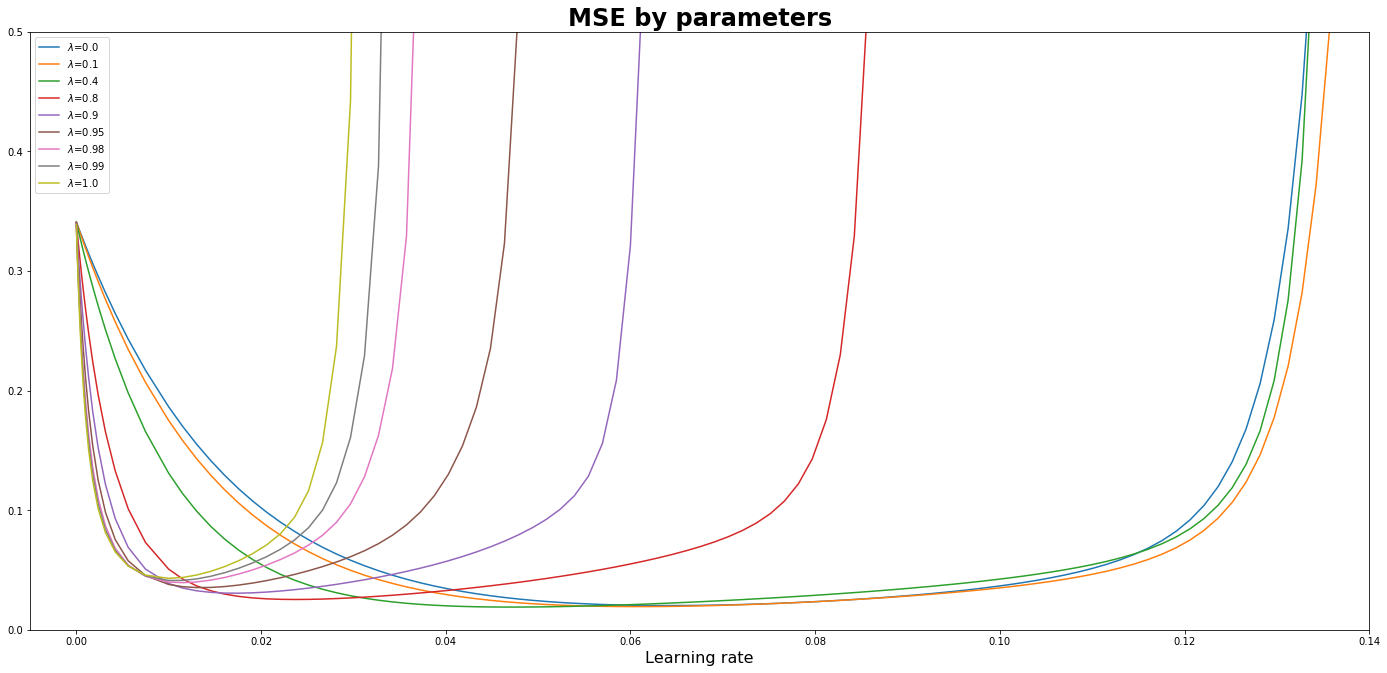

In [0]:
pyplot.figure(figsize=(24,11))
# plotting all the means together
# confidence intervals will follow
colors_ = cycle(mcolors.TABLEAU_COLORS)
for lamb in lambdas:
    idxs = [i for i,(lr, lam) in enumerate(params) if lam == lamb]
    msves_ = msves[idxs]
    stds = msves_stds[idxs]
    col = next(colors_)
    pyplot.plot(learning_rates,msves_,c=col, label="$\lambda$={}".format(lamb))

pyplot.ylim(0.0,0.5)
pyplot.xlim(-0.005,0.14)
pyplot.legend(loc="best")
pyplot.title("MSE by parameters", fontsize=24, fontweight="bold");
pyplot.xlabel("Learning rate", fontsize=16);

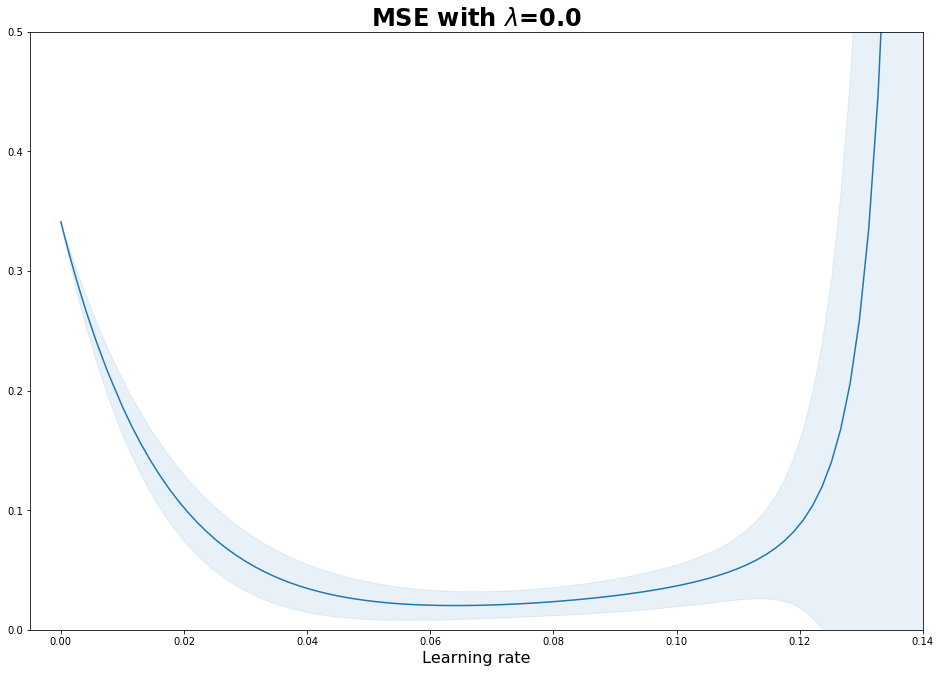

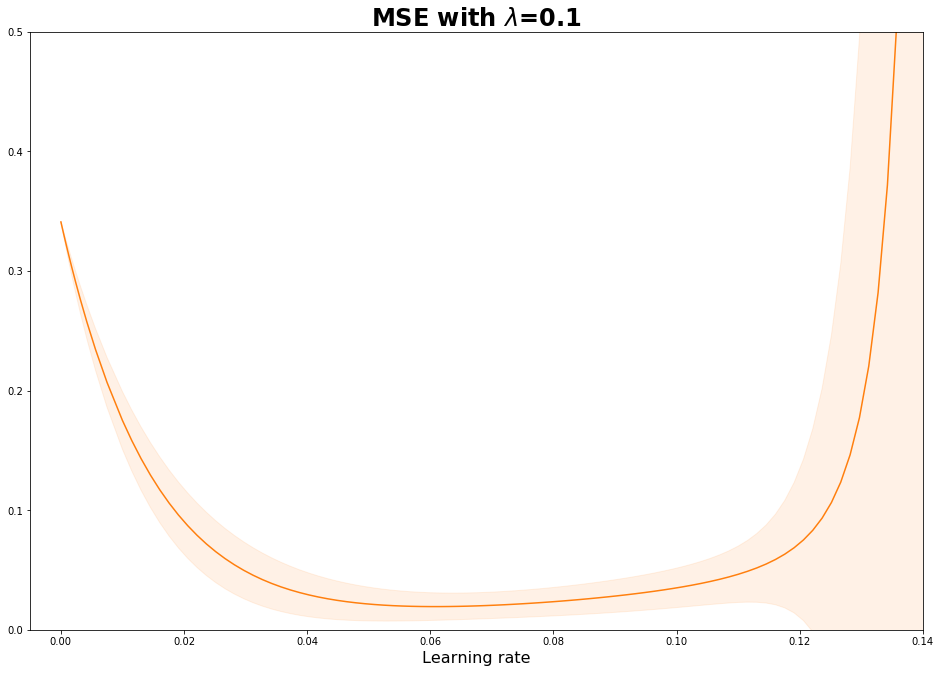

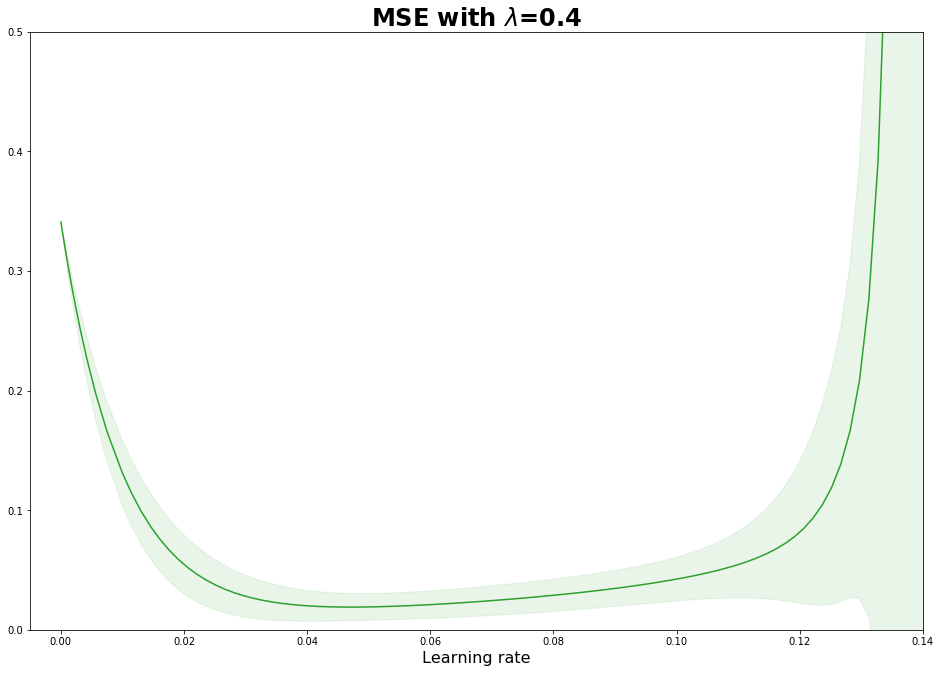

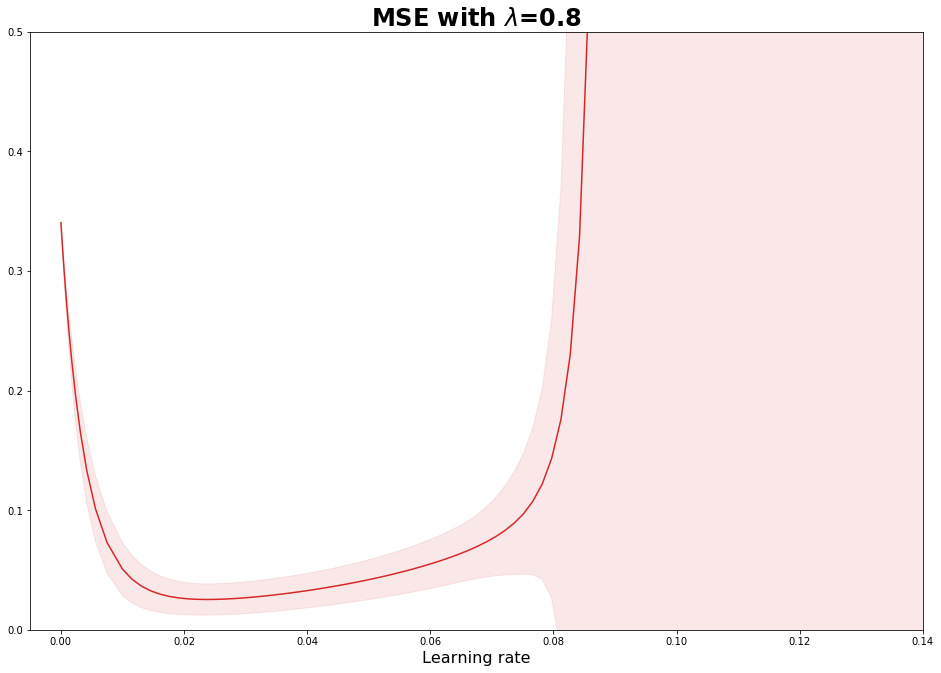

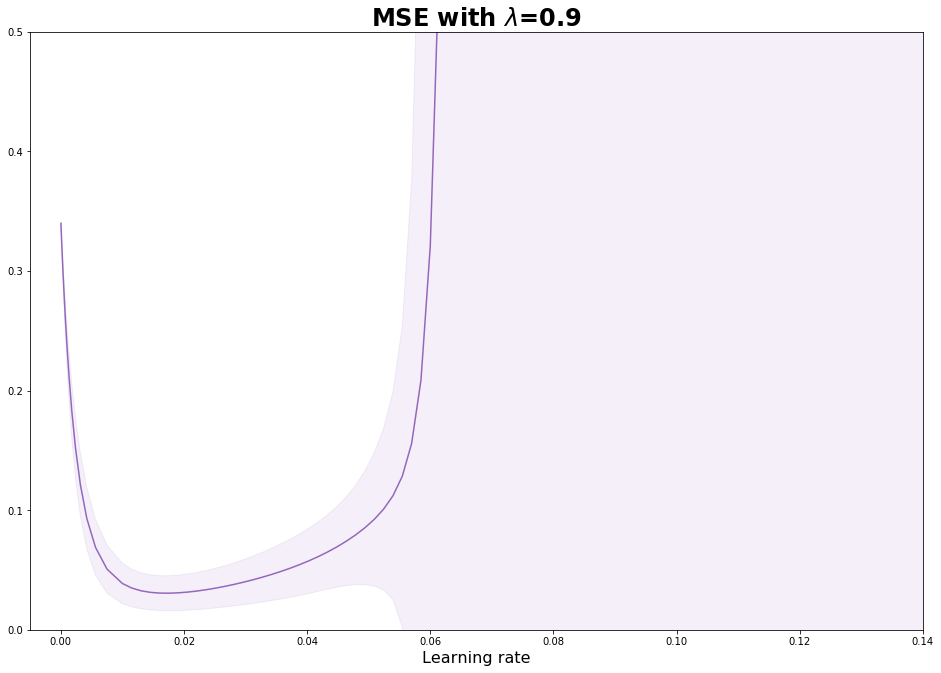

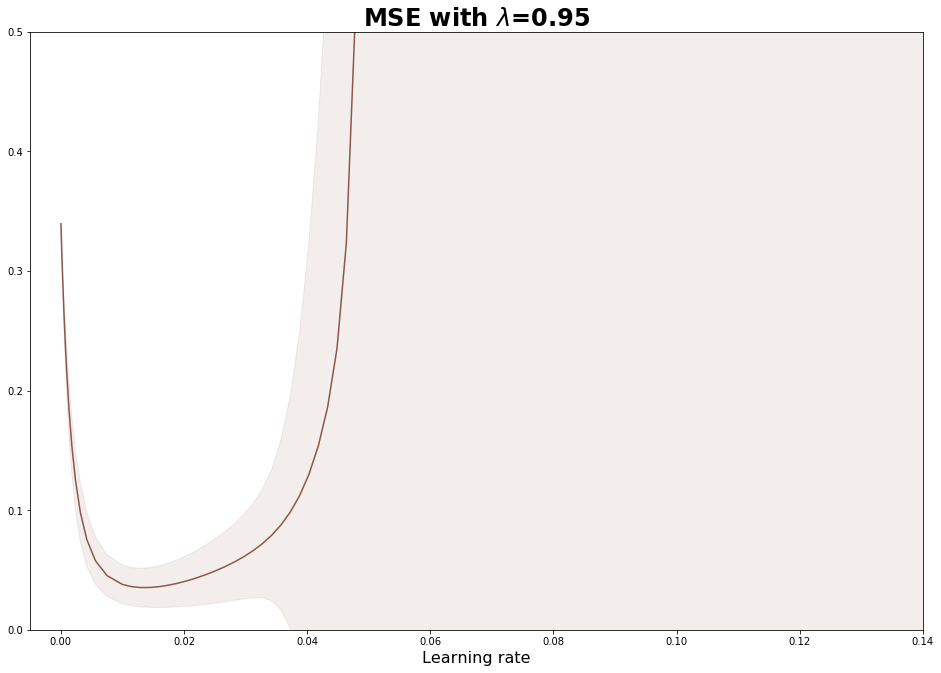

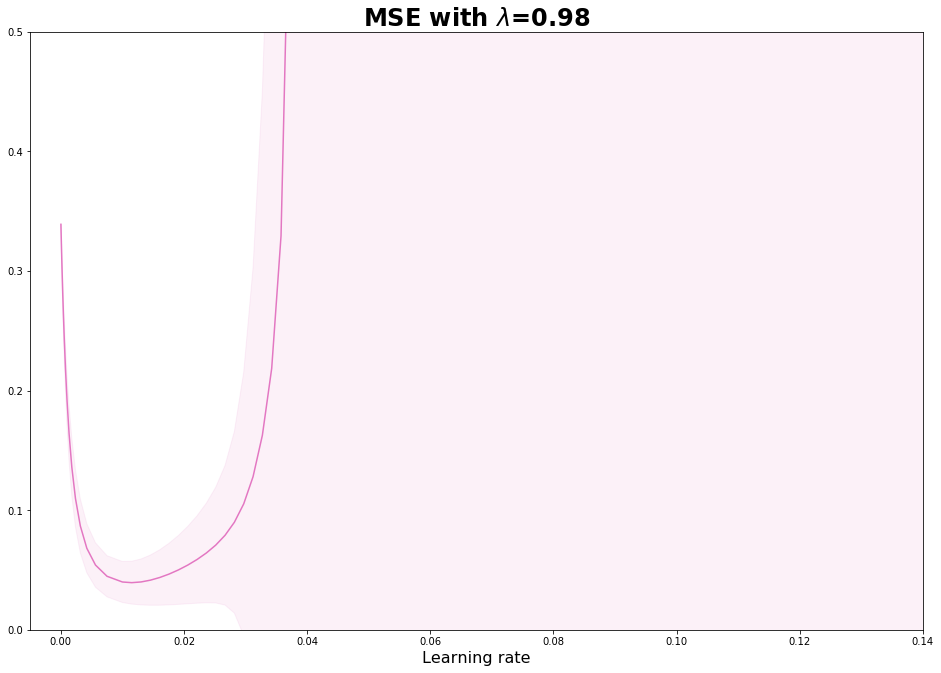

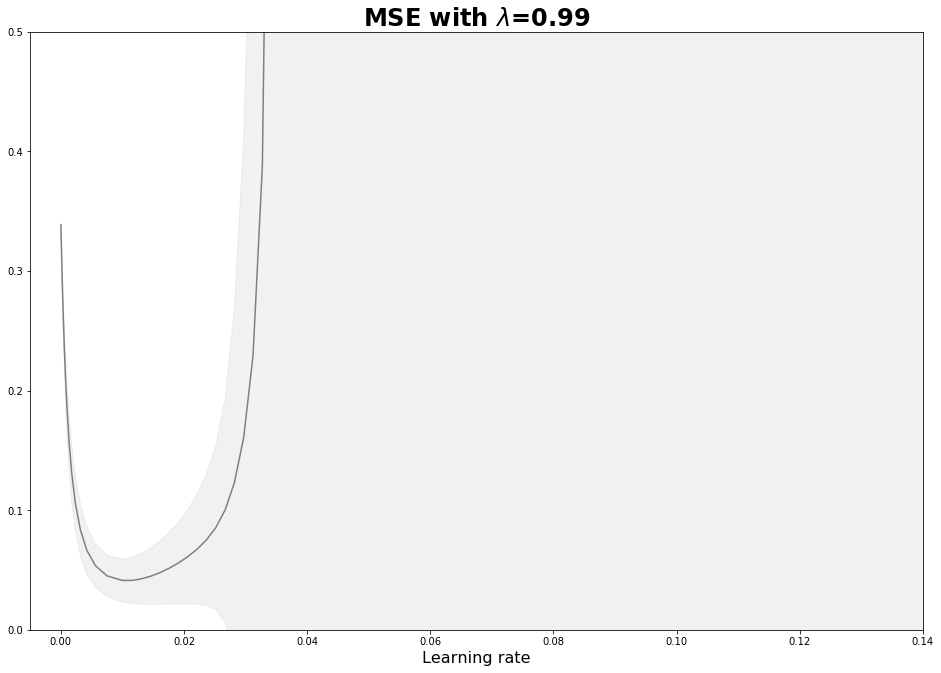

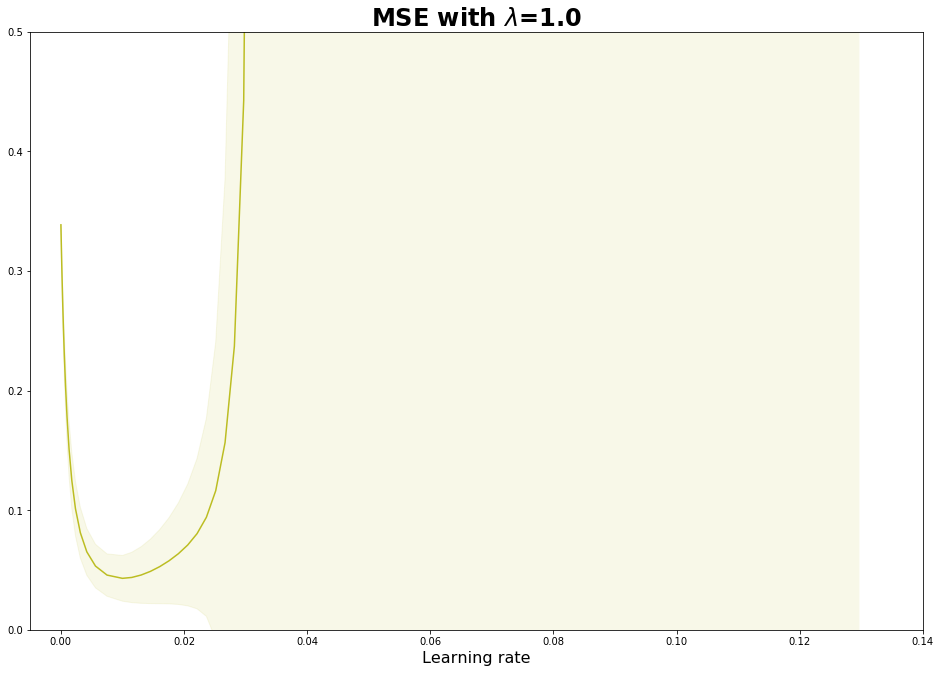

In [0]:
colors_ = cycle(mcolors.TABLEAU_COLORS)
for lamb in lambdas:
    # I know it may seems to be more intuitive 
    # to put everything on one plot,
    # but you what, funny story,
    # since there shall be confidence intervals
    # and confidence intervals unlike means are areas
    # Painted areas.
    # Thus we have a lot of colored wide overlapping areas
    # Just look on the previous figure to estimate how tightly 
    # curves packed. It would be a mess, surely
    # Nicely rainbow colored, but anyway
    # By the way, thank you for reading up till this moment.
    # Oh! almost forgot, we have confidence intervals
    # colored in the same way as its curve.
    pyplot.figure(figsize=(16,11))
    idxs = [i for i,(lr, lam) in enumerate(params) if lam == lamb]
    msves_ = msves[idxs]
    stds = msves_stds[idxs]
    col = next(colors_)
    pyplot.plot(learning_rates,msves_,c=col)
    # confidence interval of one std is used here
    # so around 68% of all cureves shall fall into
    pyplot.fill_between(learning_rates, msves_ - stds, msves_ + stds, color=col, alpha=0.1)

    pyplot.ylim(0.0,0.5)
    pyplot.xlim(-0.005,0.14)
    pyplot.title("MSE with $\lambda$={}".format(lamb), fontsize=24, fontweight="bold");
    pyplot.xlabel("Learning rate", fontsize=16)

Text(0.5, 0, 'Learning rate')

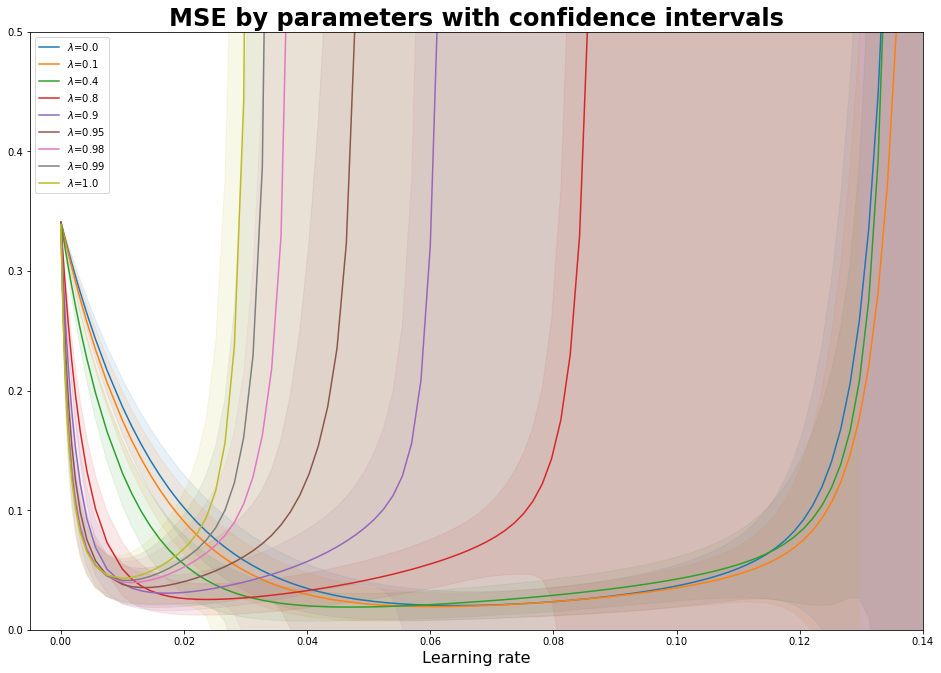

In [0]:
colors_ = cycle(mcolors.TABLEAU_COLORS)
pyplot.figure(figsize=(16,11))
for lamb in lambdas:
    # Just in case you still have doubts 
    # that everything is going to
    # overlap with everything I have this figure
    idxs = [i for i,(lr, lam) in enumerate(params) if lam == lamb]
    msves_ = msves[idxs]
    stds = msves_stds[idxs]
    col = next(colors_)
    pyplot.plot(learning_rates,msves_,c=col,label="$\lambda$={}".format(lamb))
    # confidence interval of one std is used here
    # so around 68% of all cureves shall fall into
    pyplot.fill_between(learning_rates, msves_ - stds, msves_ + stds, color=col, alpha=0.1)

pyplot.ylim(0.0,0.5)
pyplot.xlim(-0.005,0.14)
pyplot.legend(loc="best")
pyplot.title("MSE by parameters with confidence intervals".format(lamb), fontsize=24, fontweight="bold");
pyplot.xlabel("Learning rate", fontsize=16)

### Results discussion

First observation i have made that after fome point of learning rate error, independently of chosen trace decay rate, blows up in the most unplesant way. 
I presume it depends on the environment.
In our case this border is around $\alpha = 0.14$

Second observation, at some point of learning rate error blows up independently of trace decay rate, but the upper bound of an interval-withour-blow  depends on decay rate. For the higher decay rates it is more narrow and upper bound is closer to zero than for lower decay rates.

Third observation, for each error curve we have minimum of error over learning rate. Therefore for each decay rate we can find suitable learning rate to achive minimum of error on this decay rate. However, minimums are smaller for the smaller decay rate, so it is easier to do it for smaller decay rates.

Forth observation, those minimums they become approximately the same for $\lambda \leq 0.4$. 
So we have a region where minimun of error does not depend of decay rates (almost) and only of learning rate.
 